In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#import pandas as pd
import numpy as np
#import autograd.numpy as np   # Thinly-wrapped version of Numpy
#from autograd import grad

import GPy
from GPy.kern import Kern
from GPy import Param, Model

#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.pipeline import make_pipeline
#from sklearn.linear_model import LinearRegression
#from sklearn.datasets import fetch_openml

In [2]:
%ls airline.csv

airline.csv


In [3]:
air = np.loadtxt('airline.csv')

x = air[: ,0]
y = air[:, 1]
stop = 96

In [4]:
# load dataset
#x, y = load_mauna_loa_atmospheric_co2()

from sklearn import preprocessing
import random

random.seed(23)

idx = random.sample(range(len(x)), 50)

x_new = (x - min(x))/(max(x)-min(x))

scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))

y_new = scaler.transform(y.reshape(-1,1))


#train_gx = x_new[idx][:,None]
#train_gy = y_new[idx] + 0.0001 * np.random.normal(0,1,50)[:,None]

train_x = x_new[:stop][:,None]
train_y = y_new[:stop]

test_x = x_new[stop:][:,None]
test_y = y_new[stop:]

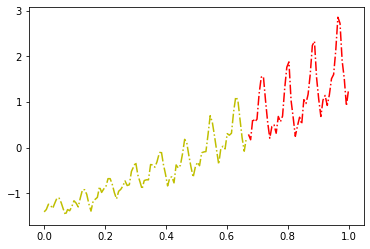

In [5]:
plt.plot(train_x,train_y, 'y-.')
plt.plot(test_x,test_y, 'r-.')

In [6]:
from numpy.linalg import inv
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel

In [7]:
N = 5

def dg_dw(w, x):
    tmp1 = w[2] * x * (1-np.tanh(w[0]*x+w[1])**2)
    tmp2 = w[2] * (1-np.tanh(w[0]*x+w[1])**2)
    tmp3 = np.tanh(w[0]*x+w[1])
    tmp4 = np.ones((tmp1.shape[0],1))
    return np.hstack((tmp1,tmp2,tmp3,tmp4))

class MFRBF_grad(Kern):
    
    def __init__(self, input_dim, std1=1., lengthscale1=1., std2=1., lengthscale2=1., Xg=None, w_net=None, active_dims=None):
        super(MFRBF_grad, self).__init__(input_dim, active_dims, 'MFRBF_grad')
        self.std1 = Param('std1', std1)
        self.std2 = Param('std2', std2)
        self.lengthscale1 = Param('lengthscale1', lengthscale1)
        self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.Xg = Xg
        #self.g = g
        #self.link_parameters(self.std1, self.std2, self.lengthscale1, self.lengthscale2)
        self.w_net = Param('network parameters', w_net)
        self.link_parameters(self.std1, self.std2, self.lengthscale1, self.lengthscale2, self.w_net)
        
    def parameters_changed(self):
        pass
    
    def _neural_network(self, x):
        #N = 5
        w1 = self.w_net.values[:N]
        b1 = self.w_net.values[N:2*N]
        w2 = self.w_net.values[2*N:3*N]
        b2 = self.w_net.values[3*N:]
        return np.sum(w2*np.tanh(w1*x+b1)+b2)
        
    def _compute_g_values(self, X):
        tmp_f = lambda _x: self._neural_network(_x)
        return np.array(list(map(tmp_f, X))).reshape(-1,1)
        
    def _compute_grad_net(self, X):
        g_out = []
        for i in range(N):
            w_tmp = self.w_net.values[i::N]
            tmp_g = dg_dw(w_tmp, X)
            g_out.append(tmp_g)
        return np.array(g_out)
        
    def K(self, X, X2):
        #help(self.g)
        #print(self.g.values)
        values = self._compute_g_values(self.Xg)
        K1 = GPy.kern.RBF(input_dim=self.input_dim,variance=self.std1**2,lengthscale=self.lengthscale1)
        m1 = GPy.models.GPRegression(self.Xg, values, K1, noise_var = 0.0001)
        
        if X2 is None:
            mu, v = m1.predict(X, full_cov = True)

            dmu2 = euclidean_distances(mu,squared=True)
            cxx = np.repeat(v.diagonal(), v.shape[0]).reshape(v.shape[0], v.shape[1])
            cyy = np.transpose(cxx)
            delta2 = cxx + cyy - 2.*v
            delta2 = delta2 + self.lengthscale2**2*np.ones((v.shape[0],v.shape[0]))

            mat_exp = np.exp((-0.5)*np.divide(dmu2,delta2))
            mat_sqrt = delta2/self.lengthscale2**2
            mat_sqrt = self.std2**2 * np.power(mat_sqrt, -0.5)

            m_eff = np.multiply(mat_sqrt, mat_exp)
        else:
            X_new = np.vstack((X,X2))
            mu, v = m1.predict(X_new, full_cov=True)
            m_eff = np.zeros((X.shape[0],X2.shape[0]))
            L1 = X.shape[0]
            L2 = X2.shape[0]

            dmu2 = euclidean_distances(mu[:L1],mu[L1:],squared=True)
            diag1 = v.diagonal()[:L1]
            diag2 = v.diagonal()[L1:]

            # directly generate matrix representing cxx+cyy-2cxy 
            cxx = np.repeat(diag1, L2).reshape(L1,L2)
            cyy = np.repeat(diag2, L1).reshape(L2, L1)
            cyy = np.transpose(cyy)

            delta2 = cxx + cyy - 2.* v[:L1, L1:]
            delta2 = delta2 + self.lengthscale2**2 * np.ones((L1,L2))

            mat_exp = np.exp((-0.5)*np.divide(dmu2,delta2))
            mat_sqrt = delta2/self.lengthscale2**2
            mat_sqrt = self.std2**2 * np.power(mat_sqrt, -0.5)

            m_eff = np.multiply(mat_sqrt, mat_exp)
            
        return m_eff
    
    def Kdiag(self,X):
        return self.std2**2*np.ones(len(X))
    
    # derivative of rbf(x1,x2) with respect to lengthscale1
    def _dKdl(self,X, X2):
        if X2 is None:
            x=X.reshape(-1,1)
            tmpd2 = self.lengthscale1**(-3) * euclidean_distances(x,squared=True)
            tmprbf = self.std1**2 * rbf_kernel(x, gamma = 0.5*self.lengthscale1**(-2))
            return np.multiply(tmprbf, tmpd2)
        else:
            x=X.reshape(-1,1)
            y=X2.reshape(-1,1)
            tmpd2 = self.lengthscale1**(-3)*euclidean_distances(x,y,squared=True)
            tmprbf = self.std1**2 * rbf_kernel(x, y, gamma = 0.5*self.lengthscale1**(-2))
            return np.multiply(tmprbf, tmpd2)
        
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
        
        Kg = self.std1**2 * rbf_kernel(self.Xg, gamma = 0.5*self.lengthscale1**(-2))
        Kg += 0.00001 * np.identity(Kg.shape[0])
        Kg_inv = inv(Kg)
        
        Kxg = self.std1**2 * rbf_kernel(X, self.Xg, gamma = 0.5*self.lengthscale1**(-2))
        Kxx = self.std1**2 * rbf_kernel(X, gamma = 0.5*self.lengthscale1**(-2))

        values = self._compute_g_values(self.Xg)
        
        alpha = np.matmul(Kg_inv, values)
        Q = np.matmul(Kxg,Kg_inv)
        mu = np.matmul(Kxg, alpha)
        v = Kxx - np.matmul(np.matmul(Q, Kg), np.transpose(Q))

        dmu2 = euclidean_distances(mu,squared=True)
        cxx = np.repeat(v.diagonal(), v.shape[0]).reshape(v.shape[0], v.shape[1])
        cyy = np.transpose(cxx)
        delta1 = cxx + cyy - 2.*v
        delta2 = delta1 + self.lengthscale2**2*np.ones((v.shape[0],v.shape[0]))

        dmu1 = mu.reshape(-1,1) - mu.reshape(1,-1)

        mat_exp = np.exp((-0.5)*np.divide(dmu2,delta2))
        mat_sqrt = delta2/self.lengthscale2**2
        mat_sqrt = self.std2**2 * np.power(mat_sqrt, -0.5)
        m_eff = np.multiply(mat_sqrt, mat_exp)

        dKdmuxy = np.multiply(m_eff, np.divide((-1.)*dmu1,delta2))

        dKddelta2 = -0.5 * np.divide(np.ones((v.shape[0],v.shape[0])),delta2)
        dKddelta2 = dKddelta2 + 0.5*np.divide(dmu2, np.power(delta2, 2))
        dKddelta2 = np.multiply(m_eff, dKddelta2)

        dmudl = np.matmul(self._dKdl(X,self.Xg), alpha) 
        dmudl -= np.matmul(Q, np.matmul(self._dKdl(self.Xg, None),alpha))
        dmuxydl = dmudl.reshape(-1,1) - dmudl.reshape(1,-1)

        ddelta2dl = self._dKdl(X,None) - np.matmul(self._dKdl(X,self.Xg), np.transpose(Q))
        ddelta2dl += np.matmul(np.matmul(Q, self._dKdl(self.Xg, None)), np.transpose(Q))
        ddelta2dl -= np.matmul(Q, self._dKdl(self.Xg, X))

        dstd1 = 2. * delta2 / self.std1
        dstd1 = np.multiply(dKddelta2, dstd1)
        
        dl1 = np.multiply(dKdmuxy, dmuxydl) 
        dl1 += np.multiply(dKddelta2, ddelta2dl)

        dstd2 = 2*m_eff/self.std2

        dl2_1 = np.divide(delta1,delta2)/self.lengthscale2
        dl2_2 = np.divide(dmu2,np.power(delta2,2))*self.lengthscale2
        dl2 = np.multiply(m_eff, dl2_1+dl2_2)

        self.std1.gradient = np.sum(dstd1*dL_dK)
        self.std2.gradient = np.sum(dstd2*dL_dK)
        self.lengthscale2.gradient = np.sum(dl2*dL_dK)
        self.lengthscale1.gradient = np.sum(dl1*dL_dK)
        
        #grad_nn = self._compute_grad_net(Xg)
        
        #for i in range(len(self.w_net.values)):
        #    for j in range(len(self.w_net.values[i])):
                
        
        #for w in self.w_net.values:
        
        #dgg = np.zeros((self.g.values.shape[0],1))
        
        gg_net = self._compute_grad_net(self.Xg)
        
        for i in range(N):
            
            tmp_1 = np.matmul(Q,gg_net[i][:,0])
            tmp_w1 = tmp_1.reshape(-1,1) - tmp_1.reshape(1,-1)
            tmp_w1 = np.multiply(dKdmuxy, tmp_w1)
            self.w_net[i].gradient = np.sum(tmp_w1*dL_dK)
            
            tmp_2 = np.matmul(Q,gg_net[i][:,1])
            tmp_b1 = tmp_2.reshape(-1,1) - tmp_2.reshape(1,-1)
            tmp_b1 = np.multiply(dKdmuxy, tmp_b1)
            self.w_net[i+N].gradient = np.sum(tmp_b1*dL_dK)
            
            tmp_3 = np.matmul(Q,gg_net[i][:,2])
            tmp_w2 = tmp_3.reshape(-1,1) - tmp_3.reshape(1,-1)
            tmp_w2 = np.multiply(dKdmuxy, tmp_w2)
            self.w_net[i+N*2].gradient = np.sum(tmp_w2*dL_dK)
            
            tmp_4 = np.matmul(Q,gg_net[i][:,3])
            tmp_b2 = tmp_4.reshape(-1,1) - tmp_4.reshape(1,-1)
            tmp_b2 = np.multiply(dKdmuxy, tmp_b2)
            self.w_net[i+N*3].gradient = np.sum(tmp_b2*dL_dK)
        #    tmp_t = Q[:,i].reshape(-1,1)-Q[:,i].reshape(1,-1)
        #    dg = np.multiply(dKdmuxy,tmp_t)
        #    dgg[i] = np.sum(dg*dL_dK)
        
        
            
        #self.w_net.gradient = np.sum(dg*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.std2.gradient = 2.*slef.std2*np.sum(dL_dKdiag)
        #self.std2.gradient = np.sum(dL_dKdiag)
        
    def gradients_X(self,dL_dK,X,X2):
        if X2 is None: X2 = X
        pass
    
    def gradients_X_diag(self,dL_dKdiag,X):
        pass
            

In [8]:
num_cheap = 13
# 37 with logML -7.07
#num_expensive = 10

np.random.seed(159)
X1 = np.random.rand(num_cheap)[:,None]

In [9]:
w_net = np.random.normal(0,1,size=(N*4,1))

In [10]:
print(w_net)

[[-0.83897531]
 [-1.20395186]
 [ 0.92424542]
 [-1.82162686]
 [-2.38408637]
 [ 0.31371651]
 [-0.32448961]
 [-1.60126404]
 [ 0.60352909]
 [-0.14817642]
 [-1.94293586]
 [-0.61206179]
 [ 0.51707881]
 [-0.44636495]
 [-0.25732095]
 [-0.94984045]
 [ 0.14837969]
 [-0.73513349]
 [ 0.44652944]
 [-0.22450779]]


In [11]:
w_net[4::5]

array([[-2.38408637],
       [-0.14817642],
       [-0.25732095],
       [-0.22450779]])

In [12]:
K = MFRBF_grad(input_dim = 1, std1=1., lengthscale1=1., std2=1., lengthscale2 = 1., Xg = X1, w_net = w_net)

In [13]:
tmp=K._compute_g_values(X1)

In [14]:
tmp.shape

(13, 1)

In [15]:
X1.shape

(13, 1)

In [16]:
gg = K._compute_grad_net(X1)

In [17]:
gg.shape

(5, 13, 4)

In [18]:
gg[0].shape

(13, 4)

In [19]:
type(gg[0])

numpy.ndarray

In [20]:
print(K.w_net)

  index    |  MFRBF_grad.network_parameters  |  constraints  |  priors
  [0 0]    |                    -0.83897531  |               |        
  [1 0]    |                    -1.20395186  |               |        
  [2 0]    |                     0.92424542  |               |        
  [3 0]    |                    -1.82162686  |               |        
  [4 0]    |                    -2.38408637  |               |        
  [5 0]    |                     0.31371651  |               |        
  [6 0]    |                    -0.32448961  |               |        
  [7 0]    |                    -1.60126404  |               |        
  [8 0]    |                     0.60352909  |               |        
  [9 0]    |                    -0.14817642  |               |        
  [10  0]  |                    -1.94293586  |               |        
  [11  0]  |                    -0.61206179  |               |        
  [12  0]  |                     0.51707881  |               |        
  [13 

In [21]:
print(K.w_net[0].gradient)

[0.83897531]


In [22]:
K.w_net.values

array([[-0.83897531],
       [-1.20395186],
       [ 0.92424542],
       [-1.82162686],
       [-2.38408637],
       [ 0.31371651],
       [-0.32448961],
       [-1.60126404],
       [ 0.60352909],
       [-0.14817642],
       [-1.94293586],
       [-0.61206179],
       [ 0.51707881],
       [-0.44636495],
       [-0.25732095],
       [-0.94984045],
       [ 0.14837969],
       [-0.73513349],
       [ 0.44652944],
       [-0.22450779]])

In [23]:
#num_cheap = 23

x_co2 = np.linspace(0,1,num_cheap)[:,None]

In [24]:
K = MFRBF_grad(input_dim = 1, std1=1., lengthscale1=1., std2=1., lengthscale2 = 1., Xg = x_co2, w_net = w_net)

In [25]:
#train_x = x_new[:200][:,None]
#train_y = y_new[:200]

#test_x = x_new[200:][:,None]
#test_y = y_new[200:]

m = GPy.models.GPRegression(train_x, train_y, K, noise_var = 0.0001)

In [31]:
m.optimize()
m.optimize_restarts(num_restarts = 60)

Optimization restart 1/30, f = 0.21888476480452823
Optimization restart 2/30, f = 11.428169762014186
Optimization restart 3/30, f = 11.188418190255625
Optimization restart 4/30, f = 11.253399970428433
Optimization restart 5/30, f = 11.167273856454045
Optimization restart 6/30, f = 10.72487231807473
Optimization restart 7/30, f = 8.491378373552969
Optimization restart 8/30, f = 11.13798194216281
Optimization restart 9/30, f = 11.109307711552077
Optimization restart 10/30, f = 11.18712053439102
Optimization restart 11/30, f = 11.15410331929526
Optimization restart 12/30, f = 11.065191693113839
Optimization restart 13/30, f = 10.603065996966215
Optimization restart 14/30, f = 11.00887520663089
Optimization restart 15/30, f = 11.004585516210014
Optimization restart 16/30, f = 11.097154686237992
Optimization restart 17/30, f = 10.117125412433829
Optimization restart 18/30, f = 11.078077109845331
Optimization restart 19/30, f = 11.478255128458045
Optimization restart 20/30, f = 10.6314791061

 /Users/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning:overflow encountered in exp
 /Users/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning:invalid value encountered in power


Optimization restart 27/30, f = 14.367255568962022
Optimization restart 28/30, f = -28.50005165129126
Optimization restart 29/30, f = 10.888807899607002
Optimization restart 30/30, f = 11.387553127859007


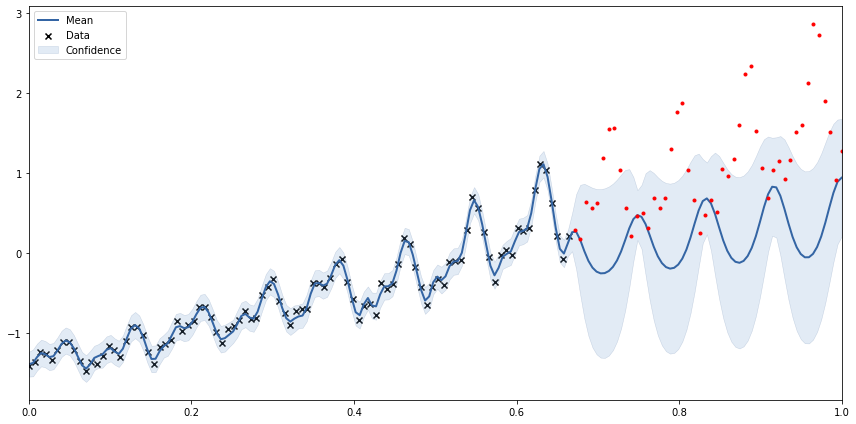

In [32]:
m.plot([0,1],figsize=(12,6))
plt.plot(test_x,test_y,'r.')

In [35]:
print(m)


Name : GP regression
Objective : -28.50005165129126
Number of Parameters : 25
Number of Optimization Parameters : 25
Updates : True
Parameters:
  GP_regression.                 |                 value  |  constraints  |  priors
  MFRBF_grad.std1                |    -3.033097733750957  |               |        
  MFRBF_grad.std2                |   -0.7346077098486204  |               |        
  MFRBF_grad.lengthscale1        |  0.026454653483365297  |               |        
  MFRBF_grad.lengthscale2        |    2.1891902409694364  |               |        
  MFRBF_grad.network_parameters  |               (20, 1)  |               |        
  Gaussian_noise.variance        |  0.004359063410402152  |      +ve      |        


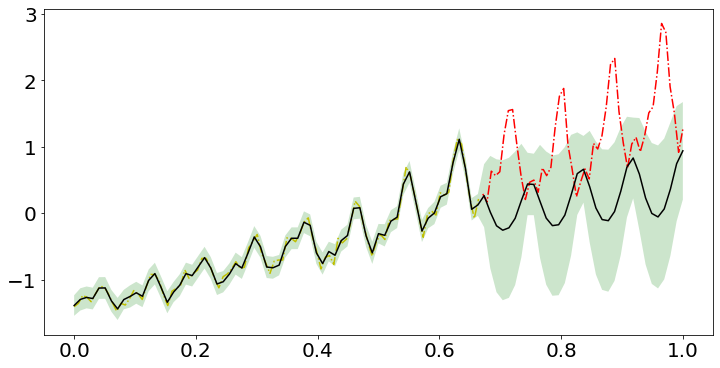

In [49]:
X_test = np.linspace(0,1,99)[:,None]

mean, var = m.predict(X_test)

X_plot = np.linspace(0,1,200)[:,None]

pred_up = mean + 1.96 * np.sqrt(var)
pred_down = mean - 1.96 * np.sqrt(var)

import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(test_x,test_y,'r-.')
plt.plot(train_x,train_y,'y-.')
#plt.plot(X_plot,f_e,'r-.')
#plt.plot(X_plot,f_c,'b.')
plt.plot(X_test, mean,'k-',linewidth=1.5)
#plt.title('SE[SE]')
plt.fill_between(np.array(X_test).flatten(),np.array(pred_up).flatten(),np.array(pred_down).flatten(),facecolor='g',alpha=0.2)

In [50]:
fig.savefig('demo_airline_cDGP2_a_good.pdf', bbox_inches='tight')

In [38]:
m.log_likelihood()

28.50005165129126

In [51]:
print(m)


Name : GP regression
Objective : -28.50005165129126
Number of Parameters : 25
Number of Optimization Parameters : 25
Updates : True
Parameters:
  GP_regression.                 |                 value  |  constraints  |  priors
  MFRBF_grad.std1                |    -3.033097733750957  |               |        
  MFRBF_grad.std2                |   -0.7346077098486204  |               |        
  MFRBF_grad.lengthscale1        |  0.026454653483365297  |               |        
  MFRBF_grad.lengthscale2        |    2.1891902409694364  |               |        
  MFRBF_grad.network_parameters  |               (20, 1)  |               |        
  Gaussian_noise.variance        |  0.004359063410402152  |      +ve      |        


In [52]:
np.save('gp_params_airline.npy',m.param_array)

In [53]:
print(m.param_array)

[-3.03309773 -0.73460771  0.02645465  2.18919024 -0.30844275 -1.88641484
 -1.25795588 -2.14087297 -0.65807182 -0.020155    1.13061358 -1.06476819
  1.40498338 -0.20209075  0.2255146  -1.62158593 -1.58269243 -1.34991297
 -0.95435306 -0.24277876 -0.8779827  -0.23153734  1.96402357  0.06486636
  0.00435906]


In [54]:
m1 = GPy.models.GPRegression(train_x, train_y, K, noise_var = 0.0001, initialize=False)
m1.update_model(False) # do not call the underlying expensive algebra on load
m1.initialize_parameter() # Initialize the parameters (connect the parameters up)
m1[:] = np.load('gp_params_airline.npy') # Load the parameters
m1.update_model(True)

#print(m1)

 /Users/felix/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


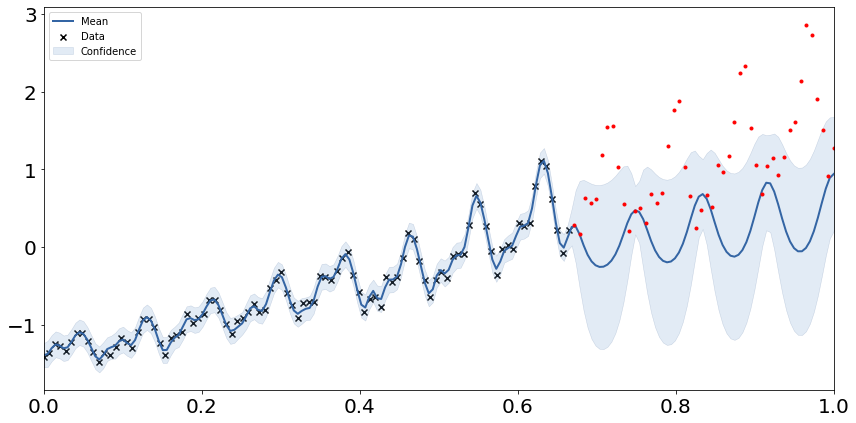

In [55]:
m1.plot([0,1],figsize=(12,6))
plt.plot(test_x,test_y,'r.')

### Demo latent layer

In [39]:
def nn(w, x):
    N = 5
    w1 = w[:N]
    b1 = w[N:2*N]
    w2 = w[2*N:3*N]
    b2 = w[3*N:]
    return np.sum(w2*np.tanh(w1*x+b1)+b2)
    #return np.sum(w2*np.maximum(0,w1*x+b1)+b2)
        
def g_values(w, X):
    tmp_f = lambda _x: nn(w,_x)
    return np.array(list(map(tmp_f, X))).reshape(-1,1)

In [40]:
g_values = g_values(m.MFRBF_grad.network_parameters.values, x_co2)

In [41]:
mu2, var2 = m.predict(X_plot)

In [42]:
K2 = GPy.kern.RBF(input_dim=1,
                  variance=m.MFRBF_grad.std1**2,
                  lengthscale=m.MFRBF_grad.lengthscale1)

# m2 refers to the first GP

m2 = GPy.models.GPRegression(x_co2, g_values, K2, noise_var = 0.0001)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fbf7839e860>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fbf7839e7f0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fbf7839eeb8>]}

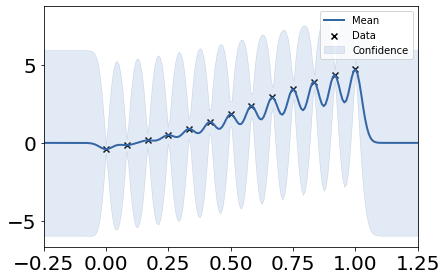

In [43]:
m2.plot()

In [44]:
mu1, var1 = m2.predict(X_plot)

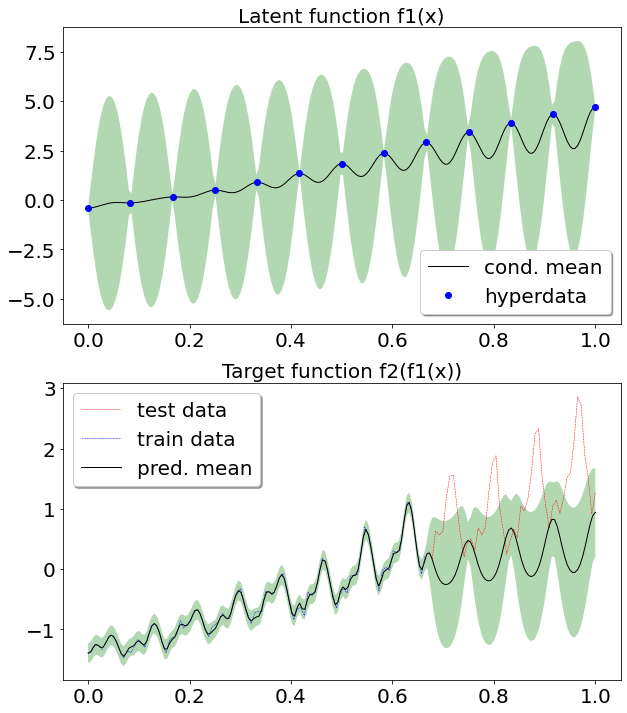

In [47]:
f = plt.figure(figsize=(10,12))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)
#ax3 = f.add_subplot(313)

#plt.subplot(3, 1, 1)
#ax1.title('g(x)')
ax1.set_title('Latent function f1(x)', fontsize=20)
ax1.plot(X_plot, mu1,'k-',linewidth=1)
ax1.plot(x_co2, g_values,'bo')
#f3_ax33.plot(x_new,y_new,'b--',linewidth=0.5)
ax1.fill_between(np.array(X_plot).flatten(),
                     np.array(mu1+1.96*np.sqrt(var1)).flatten(),
                     np.array(mu1-1.96*np.sqrt(var1)).flatten(),
                     facecolor='g',alpha=0.3)
ax1.legend(('cond. mean', 'hyperdata'), loc='lower right', shadow=True,  fontsize=20)
#ax1.text(0.1, 6.0, "activation unit = tanh", size=16)



#plt.subplot(3, 1, 3)
ax2.set_title('Target function f2(f1(x))',  fontsize=20)
ax2.plot(test_x,test_y,'r--', linewidth=0.5)
ax2.plot(train_x, train_y, 'b--', linewidth=0.5)
ax2.plot(X_plot, mu2,'k-',linewidth=1)
#plt.plot(x_h, h_values,'go')
#f3_ax33.plot(x_new,y_new,'b--',linewidth=0.5)
ax2.fill_between(np.array(X_plot).flatten(),
                     np.array(mu2+1.96*np.sqrt(var2)).flatten(),
                     np.array(mu2-1.96*np.sqrt(var2)).flatten(),
                     facecolor='g',alpha=0.3)
ax2.legend(('test data', 'train data', 'pred. mean'), loc='upper left', shadow=True,  fontsize=20)




In [48]:
f.savefig('demo_airline_2_cDGPa_good1.pdf', bbox_inches='tight')